In [1]:
from google.colab import files
uploaded = files.upload()

Saving datagenerator.py to datagenerator.py
Saving model.py to model.py


In [2]:
import os
import numpy as np
#/content/datagenerator.py  /datagenerator.py
from datagenerator import imageLoader
import keras
from matplotlib import pyplot as plt
import glob
import random
import tensorflow as tf

In [3]:
#Define the image generators for training and validation
#/content/drive/MyDrive/input_data_128
train_img_dir = "/content/drive/MyDrive/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/input_data_128/train/masks/"

val_img_dir = "/content/drive/MyDrive/input_data_128/val/images/"
val_mask_dir = "/content/drive/MyDrive/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [4]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... 
img, msk = train_img_datagen.__next__()

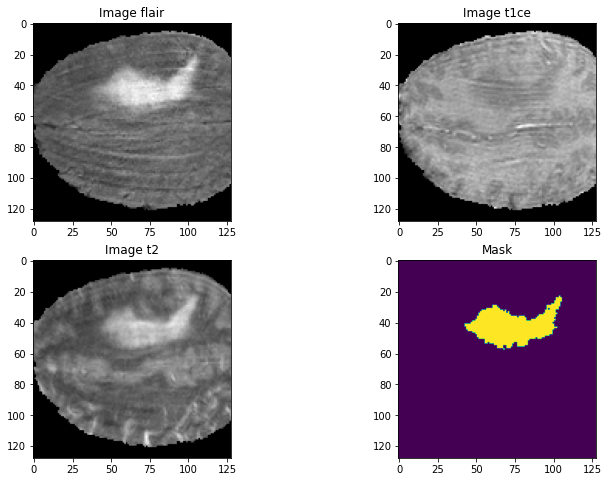

In [5]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [7]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
           sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [8]:
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


from  model import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [9]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
#print(model.summary())
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=2,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch)
model.save('/content/drive/MyDrive/brats_3d_final.hdf5')

Epoch 1/10
258/258 - 721s - loss: 0.9477 - accuracy: 0.9227 - precision: 0.9606 - recall: 0.8459 - iou_score: 0.2156 - val_loss: 0.9442 - val_accuracy: 0.8680 - val_precision: 0.9884 - val_recall: 0.7412 - val_iou_score: 0.2139 - 721s/epoch - 3s/step
Epoch 2/10
258/258 - 685s - loss: 0.9271 - accuracy: 0.9421 - precision: 0.9600 - recall: 0.9248 - iou_score: 0.2879 - val_loss: 0.9245 - val_accuracy: 0.9190 - val_precision: 0.9470 - val_recall: 0.8927 - val_iou_score: 0.3402 - 685s/epoch - 3s/step
Epoch 3/10
258/258 - 684s - loss: 0.9166 - accuracy: 0.9410 - precision: 0.9511 - recall: 0.9328 - iou_score: 0.3329 - val_loss: 0.9125 - val_accuracy: 0.9419 - val_precision: 0.9528 - val_recall: 0.9314 - val_iou_score: 0.3493 - 684s/epoch - 3s/step
Epoch 4/10
258/258 - 687s - loss: 0.9054 - accuracy: 0.9427 - precision: 0.9486 - recall: 0.9391 - iou_score: 0.3723 - val_loss: 0.9038 - val_accuracy: 0.9238 - val_precision: 0.9337 - val_recall: 0.9187 - val_iou_score: 0.3723 - 687s/epoch - 3s/s

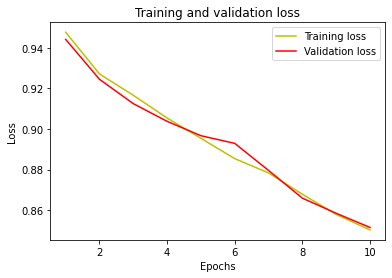

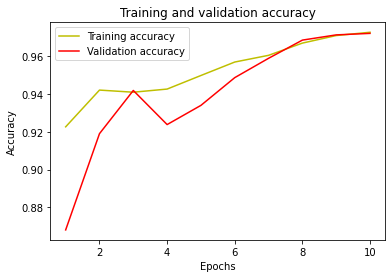

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'iou_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_iou_score'])


In [28]:
print("Loss: ",round(np.array(history.history["loss"]).mean(),2))
print("Accuracy: ",round(np.array(history.history["accuracy"]).mean(),2))
print("Precision: ",round(np.array(history.history["precision"]).mean(),2))
print("Recall: ",round(np.array(history.history["recall"]).mean(),2))
print("iou_score: ",round(np.array(history.history["iou_score"]).mean(),2))
print("val_loss: ",round(np.array(history.history["val_loss"]).mean(),2))
print("val_accuracy: ",round(np.array(history.history["val_accuracy"]).mean(),2))
print("val_precision: ",round(np.array(history.history["val_precision"]).mean(),2))
print("val_recall: ",round(np.array(history.history["val_recall"]).mean(),2))
print("val_iou_score: ",round(np.array(history.history["val_iou_score"]).mean(),2))

Loss:  0.89
Accuracy:  0.95
Precision:  0.96
Recall:  0.94
iou_score:  0.4
val_loss:  0.89
val_accuracy:  0.94
val_precision:  0.96
val_recall:  0.92
val_iou_score:  0.41


In [29]:
from keras.models import load_model
my_model = load_model('/content/drive/MyDrive/brats_3d_final.hdf5', compile=False)
                      

In [30]:
from keras.metrics import MeanIoU
batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,val_mask_dir, val_mask_list, batch_size)

In [31]:
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)


In [32]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.55104053


In [33]:
img_num = 82

test_img = np.load("/content/drive/MyDrive/input_data_128/val/images/image_"+str(img_num)+".npy") #/content/drive/MyDrive/input_data_128

test_mask = np.load("/content/drive/MyDrive/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

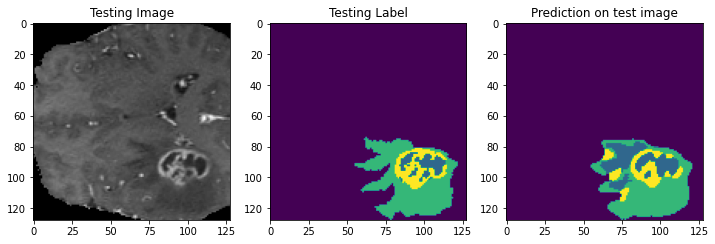

In [34]:
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()
